In [19]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import matplotlib.pyplot as plt


DATA_PATH = '../datasets/preprocessed/final_merged_clinical_miRNA.csv'
df = pd.read_csv(DATA_PATH)

# print(df.shape)
# print(df.head())
# print(df.iloc[0]['reads_per_million_miRNA_mapped'])


# Converti la colonna di stringhe in liste di float
def parse_array(x):
    if isinstance(x, str):
        x = x.strip("[]")
        return np.array([float(i) for i in x.split(",")])
    return np.array(x)


df["reads_per_million_miRNA_mapped"] = df["reads_per_million_miRNA_mapped"].apply(parse_array)
X = np.vstack(df["reads_per_million_miRNA_mapped"].values)
y = df["age_at_initial_pathologic_diagnosis"].values


scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# print(X_scaled[0])
# print(X_scaled.std(axis=0))
# print(X_scaled.mean(axis=0))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


class MiRNADataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  # Porta a vettore colonna

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


train_ds = MiRNADataset(X_train, y_train)
test_ds = MiRNADataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)


class MiRNANet(nn.Module):
    def __init__(self, input_dim=1000, hidden1=256, hidden2=128, dropout=0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.model(x)


input_dim = X_train.shape[1]
model = MiRNANet(input_dim)

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',        # riduce LR quando la metrica (loss) smette di diminuire
    factor=0.5,        # dimezza il learning rate
    patience=10        # aspetta 10 epoche senza miglioramenti
)

train_losses = []
val_losses = []

# Training loop
for epoch in range(150):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        # print(outputs)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)

    # ---- VALIDATION ----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(test_loader)

    scheduler.step(avg_val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

# Valutazione
model.eval()
with torch.no_grad():
    preds = []
    trues = []
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        preds.append(outputs.numpy())
        trues.append(y_batch.numpy())
    preds = np.vstack(preds)
    trues = np.vstack(trues)

mae = np.mean(np.abs(preds - trues))
print(f"Mean Absolute Error: {mae:.2f}")

Epoch 001 | Train Loss: 461726.4944 | Val Loss: 48692.0418
Epoch 002 | Train Loss: 33116.4308 | Val Loss: 5321.2162
Epoch 003 | Train Loss: 17979.0391 | Val Loss: 5979.1802
Epoch 004 | Train Loss: 12309.2155 | Val Loss: 4609.2137
Epoch 005 | Train Loss: 9637.2334 | Val Loss: 3862.3210
Epoch 006 | Train Loss: 7011.9315 | Val Loss: 4950.0552
Epoch 007 | Train Loss: 6165.4311 | Val Loss: 4129.3946
Epoch 008 | Train Loss: 5902.6817 | Val Loss: 3663.7242
Epoch 009 | Train Loss: 5599.5502 | Val Loss: 3930.9472
Epoch 010 | Train Loss: 4616.4557 | Val Loss: 2436.5470
Epoch 011 | Train Loss: 3710.1380 | Val Loss: 2460.1230
Epoch 012 | Train Loss: 3521.5785 | Val Loss: 1637.2464
Epoch 013 | Train Loss: 3212.2678 | Val Loss: 2388.8552
Epoch 014 | Train Loss: 3313.2166 | Val Loss: 1736.4850
Epoch 015 | Train Loss: 2611.3787 | Val Loss: 1805.6094
Epoch 016 | Train Loss: 2258.6177 | Val Loss: 1596.7534
Epoch 017 | Train Loss: 2265.9410 | Val Loss: 1967.4731
Epoch 018 | Train Loss: 1952.1497 | Val Lo

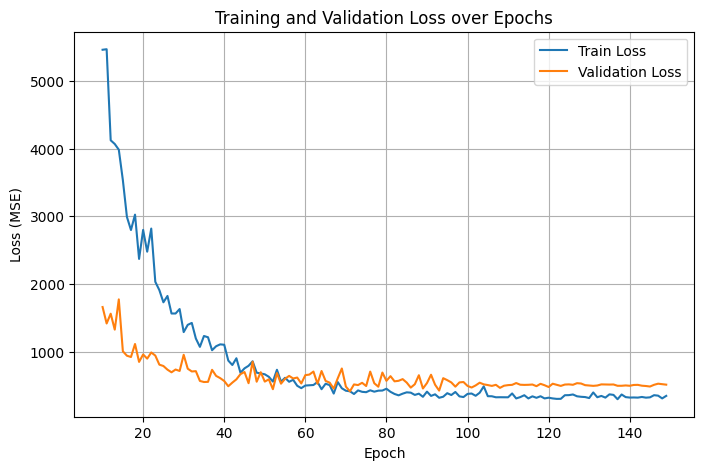

In [3]:
# === Plot delle loss ===
x = np.arange(10, len(train_losses))
plt.figure(figsize=(8,5))
plt.plot(x, train_losses[10:], label="Train Loss")
plt.plot(x, val_losses[10:], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid(True)
plt.savefig("../scripts/results/loss_plot.png", dpi=300, bbox_inches='tight')

plt.show()

In [12]:
trues_flat = trues.flatten()
preds_flat = preds.flatten()
errors = preds_flat - trues_flat

In [16]:
len(trues_flat)

152

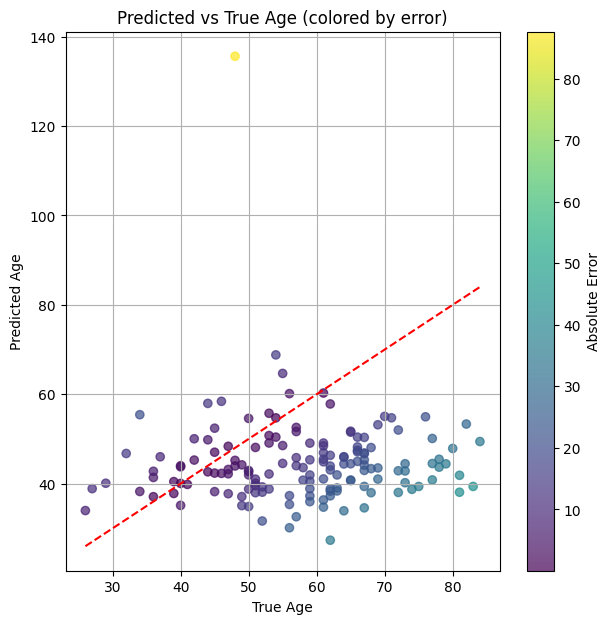

In [13]:
plt.figure(figsize=(7,7))
plt.scatter(trues_flat, preds_flat, c=np.abs(errors), cmap='viridis', alpha=0.7)
plt.plot([trues_flat.min(), trues_flat.max()], [trues_flat.min(), trues_flat.max()], 'r--')
plt.colorbar(label="Absolute Error")
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.title("Predicted vs True Age (colored by error)")
plt.grid(True)
plt.show()

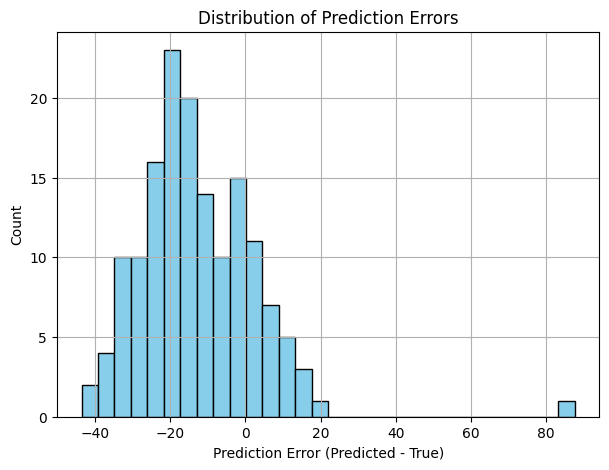

In [14]:
plt.figure(figsize=(7,5))
plt.hist(errors, bins=30, color='skyblue', edgecolor='k')
plt.xlabel("Prediction Error (Predicted - True)")
plt.ylabel("Count")
plt.title("Distribution of Prediction Errors")
plt.grid(True)
plt.show()

# GridSearch

In [3]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

In [32]:
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from skorch.callbacks import LRScheduler
import random

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DATA_PATH = '../datasets/preprocessed/final_merged_clinical_miRNA.csv'
df = pd.read_csv(DATA_PATH)

# Converti la colonna di stringhe in liste di float
def parse_array(x):
    if isinstance(x, str):
        x = x.strip("[]")
        return np.array([float(i) for i in x.split(",")])
    return np.array(x)

df["reads_per_million_miRNA_mapped"] = df["reads_per_million_miRNA_mapped"].apply(parse_array)
X = np.vstack(df["reads_per_million_miRNA_mapped"].values)
y = df["age_at_initial_pathologic_diagnosis"].values


scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train, X_test già ok come numpy array
X_train_sk = X_train.astype(np.float32)
X_test_sk = X_test.astype(np.float32)

# y deve essere 1D
y_train_sk = y_train.astype(np.float32).ravel()
y_test_sk = y_test.astype(np.float32).ravel()

  
class MiRNANet(nn.Module):
    def __init__(self, input_dim=1000, hidden1=256, hidden2=128, dropout=0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.model(x).view(-1)

# GRID SEARCH
net = NeuralNetRegressor(
    module=MiRNANet,
    module__input_dim=X_train_sk.shape[1],
    max_epochs=150,
    lr=1e-3,
    batch_size=32,
    optimizer=torch.optim.Adam,
    optimizer__weight_decay=1e-5,
    criterion=nn.MSELoss,
    callbacks=[
         ('lr_scheduler', LRScheduler(
             ReduceLROnPlateau, 
             mode='min', 
             factor=0.7, 
             patience=15, 
             monitor='valid_loss',
             min_lr=1e-6
         ))
    ],
)

params = {
    'module__hidden1': [128, 256],
    'module__hidden2': [64, 128],
    #'module__dropout': [0.2, 0.3],
    #'optimizer__weight_decay': [0, 1e-5, 1e-4],
    #'callbacks__lr_scheduler__factor': [0.8, 0.6],
    #'callbacks__lr_scheduler__patience': [15, 10],
    'lr': [1e-3, 5e-4]
}

gs = GridSearchCV(net, 
                  params, 
                  refit=True, 
                  cv=3,  # cross-validation folds 
                  scoring='neg_mean_squared_error', 
                  verbose=1)
gs.fit(X_train_sk, y_train_sk.ravel())

best_model = gs.best_estimator_
print("Best hyperparameters:", gs.best_params_)

preds = best_model.predict(X_test_sk)
mae = mean_absolute_error(y_test_sk, preds)
r2 = r2_score(y_test_sk, preds)
print(f"Test MAE: {mae:.2f} | R2: {r2:.2f}")

Fitting 3 folds for each of 8 candidates, totalling 24 fits
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1   879513.7635   132003.7247  0.0010  0.0985
      2   118872.6521    42910.1660  0.0010  0.0523
      3    49520.1470    37467.3724  0.0010  0.0603
      4    27080.5289     5059.3470  0.0010  0.0504
      5    14838.1785     5266.6162  0.0010  0.0501
      6    11355.5862     4801.8434  0.0010  0.0562
      7    10601.6461     3953.5149  0.0010  0.0612
      8     9641.3783     4797.9376  0.0010  0.0568
      9     8738.6601     2506.9422  0.0010  0.0512
     10     9450.9947     3056.8365  0.0010  0.0521
     11     6319.6251     2156.1952  0.0010  0.0524
     12     6952.4271     2689.4619  0.0010  0.0542
     13     6440.8115     1741.2079  0.0010  0.0535
     14     5961.0265     2321.6944  0.0010  0.0548
     15     4443.9346     1814.0411  0.0010  0.0570
     16     4776.2208     1545.5162  0.0010  0.0536
    

Best hyperparameters: {'lr': 0.001, 'module__hidden1': 256, 'module__hidden2': 64}
Test MAE: 11.00

In [17]:
############
# TOP MODELS
############
results = pd.DataFrame(gs.cv_results_)

# Ordina in base al punteggio (più alto = migliore, perché neg_mean_squared_error)
results_sorted = results.sort_values(by='mean_test_score', ascending=False)

# Prendi top 5
top5 = results_sorted.head(5)

# Stampa i parametri e il punteggio
for i, row in top5.iterrows():
    print(f"Rank {i+1}: mean_test_score = {row['mean_test_score']:.4f}, params = {row['params']}")

Rank 1: mean_test_score = -882.6270, params = {'lr': 0.001}
Rank 2: mean_test_score = -1147.6014, params = {'lr': 0.0005}


In [21]:
history = best_model.history
history[0].keys()

dict_keys(['batches', 'epoch', 'train_batch_count', 'valid_batch_count', 'dur', 'train_loss', 'train_loss_best', 'valid_loss', 'valid_loss_best', 'event_lr'])

In [33]:
import pandas as pd
pd.DataFrame(history)

,batches,epoch,train_batch_count,valid_batch_count,dur,train_loss,train_loss_best,valid_loss,valid_loss_best,event_lr
0,"[{'train_loss': 2319118.25, 'train_batch_size'...",1,16,4,0.093082,643433.764979,True,36026.206967,True,0.001
1,"[{'train_loss': 48782.74609375, 'train_batch_s...",2,16,4,0.096486,46352.681754,True,43324.583376,False,0.001
2,"[{'train_loss': 39315.2734375, 'train_batch_si...",3,16,4,0.090020,18563.190939,True,5756.942419,True,0.001
3,"[{'train_loss': 8843.5791015625, 'train_batch_...",4,16,4,0.087820,11773.355792,True,3924.838043,True,0.001
4,"[{'train_loss': 6597.3837890625, 'train_batch_...",5,16,4,0.096278,9208.540289,True,2860.923604,True,0.001
5,"[{'train_loss': 10835.8701171875, 'train_batch...",6,16,4,0.098142,7686.623160,True,1886.475722,True,0.001
6,"[{'train_loss': 10020.083984375, 'train_batch_...",7,16,4,0.100693,7196.624822,True,2562.570969,False,0.001
7,"[{'train_loss': 4842.0244140625, 'train_batch_...",8,16,4,0.105222,6626.319231,True,3432.633725,False,0.001
8,"[{'train_loss': 8105.23193359375, 'train_batch...",9,16,4,0.095128,5595.203974,True,3966.068351,False,0.001
9,"[{'train_loss': 6311.30419921875, 'train_batch...",10,16,4,0.102213,5912.537497,False,5878.060795,False,0.001


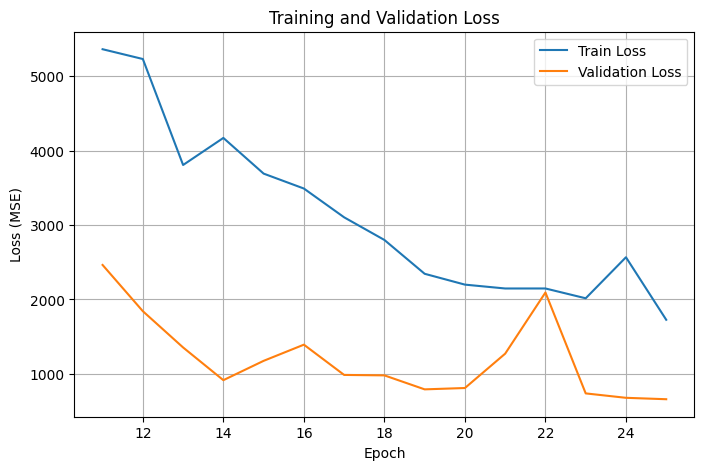

In [24]:
import matplotlib.pyplot as plt

df_history = pd.DataFrame(best_model.history)

# === Plot delle loss ===
plt.figure(figsize=(8,5))
plt.plot(df_history['epoch'][10:], df_history['train_loss'][10:], label='Train Loss')
plt.plot(df_history['epoch'][10:], df_history['valid_loss'][10:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Assicurati che siano array 1D numpy
preds_flat = preds.flatten()
trues_flat = y_test_sk.flatten()

# Calcola l'errore assoluto
errors = np.abs(preds_flat - trues_flat)

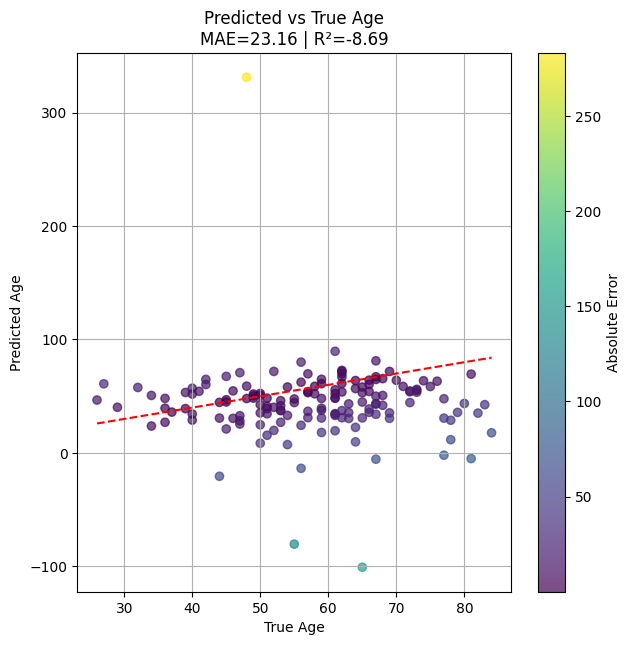

In [27]:
plt.figure(figsize=(7,7))
plt.scatter(trues_flat, preds_flat, c=errors, cmap='viridis', alpha=0.7)
plt.plot([trues_flat.min(), trues_flat.max()], [trues_flat.min(), trues_flat.max()], 'r--')
plt.colorbar(label="Absolute Error")
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.title("Predicted vs True Age (colored by error)")
plt.grid(True)
plt.show()